In [1]:
!pip install geopandas matplotlib shapely cdsapi numpy xarray rioxarray netcdf4 scipy pandas catboost scikit-learn

In [2]:
import geopandas as gpd
import ast
import shapely
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import catboost

In [3]:
def convert_gee_geo(row):
    le = ast.literal_eval(row['.geo'])
    return shapely.Polygon(le['coordinates'][0])

def read_gsw_file(loc):
    df = gpd.read_file(loc)
    df.columns = ['system:index',
     'COAST',
     'DIST_MAIN',
     'DIST_SINK',
     'ENDO',
     'HYBAS_ID',
     'MAIN_BAS',
     'NEXT_DOWN',
     'NEXT_SINK',
     'ORDER',
     'PFAF_ID',
     'SORT',
     'SUB_AREA',
     'UP_AREA',
     'water_balance',
     '.geo',
     'geometry']
    df['SUB_AREA'] = df.SUB_AREA.apply(float)
    df['.geo'] = df.apply(convert_gee_geo, axis=1)
    df.set_geometry('.geo', inplace=True)
    df.set_crs("EPSG:4326", inplace=True)
    df['water_balance'] = df.water_balance.astype(float) * df.SUB_AREA

    return df

In [4]:
# df = gpd.read_file('data/diff_hb_2010.csv')
# # df.set_geometry('.geo', inplace=True)
# df.columns = ['system:index',
#  'COAST',
#  'DIST_MAIN',
#  'DIST_SINK',
#  'ENDO',
#  'HYBAS_ID',
#  'MAIN_BAS',
#  'NEXT_DOWN',
#  'NEXT_SINK',
#  'ORDER',
#  'PFAF_ID',
#  'SORT',
#  'SUB_AREA',
#  'UP_AREA',
#  'water_balance',
#  '.geo',
#  'geometry']
# df['SUB_AREA'] = df.SUB_AREA.apply(float)

# def convert_gee_geo(row):
#     le = ast.literal_eval(row['.geo'])
#     return shapely.Polygon(le['coordinates'][0])

# df['.geo'] = df.apply(convert_gee_geo, axis=1)
# df.set_geometry('.geo', inplace=True)
# df.set_crs("EPSG:4326", inplace=True)
# ''
df = read_gsw_file(loc='data/diff_hb_2010.csv')

In [5]:
# df.crs

In [6]:
# df.head()

In [7]:
# df['water_balance'] = df.water_balance.astype(float) * df.SUB_AREA # 30m by 30m pixels / 

<Axes: >

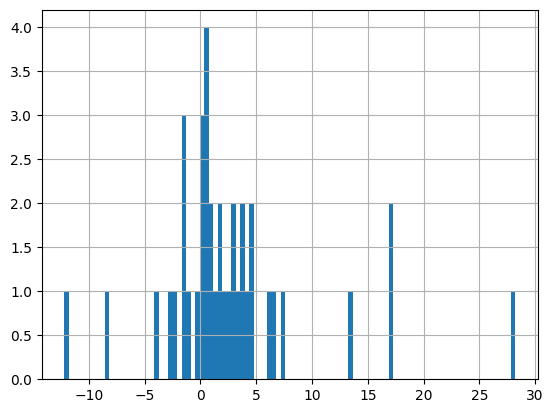

In [8]:
df.water_balance.hist(bins=100)

<Axes: >

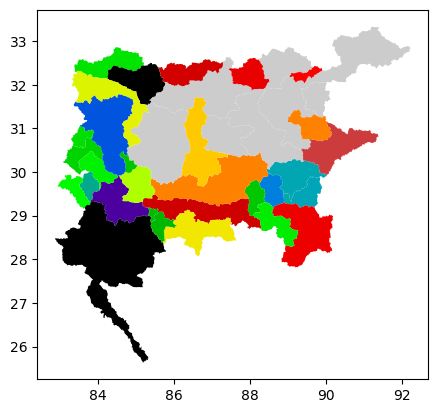

In [9]:
df.plot('water_balance', cmap='nipy_spectral', vmin=-5, vmax=5)


In [10]:
# downloaded = True

# if downloaded == False:

#     import cdsapi

#     c = cdsapi.Client()

#     years = np.arange(2012, 2022, 1)
#     days = [
#                 '01', '02', '03',
#                 '04', '05', '06',
#                 '07', '08', '09',
#                 '10', '11', '12',
#                 '13', '14', '15',
#                 '16', '17', '18',
#                 '19', '20', '21',
#                 '22', '23', '24',
#                 '25', '26', '27',
#                 '28', '29', '30',
#                 '31',
#             ]
#     months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
#     times = '23:00'
#     area = [45, 68, 24, 107]

#     for year in years:
#         year = str(year)
#         c.retrieve('reanalysis-era5-land', {'year':year, 'month':months, 'time':times, 'day':days, 'area':area
#                                            ,'variable':'total_precipitation', 'format':'netcdf.zip'}
#                   ,'precip-'+year+'netcdf.zip')

# # now we need to unzip the data
# if downloaded == False:
#     import glob
#     import shutil
#     for f in glob.glob('data/precip/*'):
#         unzipped_filename = f.split('-')[1][0:4]
#         shutil.unpack_archive(f, unzipped_filename)

In [11]:
def read_precip_data(year):
    precip = xr.open_dataset(f'data/precip/{year}data.nc')
    # precip_plusone = xr.open_dataset(f'data/precip/{year}data.nc')
    # precips = xr.concat([precip, precip_plusone], dim=['longitude', 'latitude'])
    # return precips
    return precip

def read_temp_data(year):
    temp = xr.open_dataset(f'data/temp/temp{year}.nc')
    # temp_plus
    return temp

def read_glacier_data(year):
    glac = xr.open_dataset(f'data/glacier/{year}glaciers.nc4')
    return glac

# def get_mean_std(gsw, precip):
# def get_mean_std(gsw, var, name):
def get_stats(gsw, var, name):
    
    var = var.rio.write_crs(gsw.crs)

    means = []
    stdev = []
    maxes = []
    mines = []

    for poly in gsw['.geo'].values:
        
        try:
            mean = var.rio.clip([poly], gsw.crs)[f'{name}'].mean().item()
            std = var.rio.clip([poly], gsw.crs)[f'{name}'].std().item()
            max = var.rio.clip([poly], gsw.crs)[f'{name}'].max().item()
            min = var.rio.clip([poly], gsw.crs)[f'{name}'].min().item()
            
        except:
            mean = 0
            std = 0
            max = 0
            min = 0

        means.append(mean)
        stdev.append(std)
        maxes.append(max)
        mines.append(min)
    
    gsw[f'{name}_means'] = means
    gsw[f'{name}_stdev'] = stdev
    gsw[f'{name}_max'] = maxes
    gsw[f'{name}_min'] = mines
    
    return gsw

def pipeline(year):
    gsw_data = read_gsw_file(loc=f'data/diff_hb_{year}.csv')
    precip = read_precip_data(year=year)
    temp = read_temp_data(year=year)
    glac = read_glacier_data(year=year)
    gsw_data = get_stats(gsw=gsw_data, var=precip, name='tp')
    gsw_data = get_stats(gsw=gsw_data, var=temp, name='t2m')
    glac = get_stats(gsw=gsw_data, var=glac, name='Glacier')
    gsw_data['year'] = year
    return gsw_data

In [12]:
!pip install multiprocess

In [13]:
# from multiprocessing import Pool
import multiprocess as mp
pool = mp.Pool(8)

years = np.arange(2000, 2012, 1)
dfs = pool.map(pipeline, years)
pool.close()

/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for

In [14]:
df = pd.concat(dfs)

In [15]:
df.head()

,system:index,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,tp_min,t2m_means,t2m_stdev,t2m_max,t2m_min,Glacier_means,Glacier_stdev,Glacier_max,Glacier_min,year
0,000000000000000017e6,0,2331.1,2331.1,0,4060788280,4060025450,4060786650,4060025450,1,...,0.0,268.490387,7.953619,283.411682,242.441971,-0.005459,0.005426,-0.000033,-0.010885,2000
1,000000000000000017e7,0,2413.2,2413.2,0,4060787190,4060025450,4060788280,4060025450,1,...,0.0,271.436371,6.909279,284.207489,252.633331,0.000000,0.000000,0.000000,0.000000,2000
2,000000000000000017e8,0,2439.8,2439.8,0,4060787530,4060025450,4060787190,4060025450,1,...,0.0,268.294098,6.948942,283.875916,248.422302,-0.015403,0.000000,-0.015403,-0.015403,2000
3,000000000000000017e9,0,2497.1,2497.1,0,4060787180,4060025450,4060787530,4060025450,1,...,0.0,268.866699,7.088486,283.084106,247.529694,0.000000,0.000000,0.000000,0.000000,2000
4,000000000000000017ea,0,2554.1,2554.1,0,4060785160,4060025450,4060787180,4060025450,1,...,0.0,266.136688,8.336726,281.716675,236.063736,-0.005050,0.003893,-0.001100,-0.009603,2000


In [16]:
# # years = np.arange(2000, 2022, 1)
# years = np.arange(2000, 2012, 1)
# dfs = []
# for year in years:
#     gsw_data = read_gsw_file(loc=f'data/diff_hb_{year}.csv')
#     precip = read_precip_data(year=year)
#     temp = read_temp_data(year=year)
#     # gsw_data = get_mean_std(gsw=gsw_data, precip=precip)
#     gsw_data = get_stats(gsw=gsw_data, var=precip, name='tp')
#     gsw_data = get_stats(gsw=gsw_data, var=temp, name='t2m')
#     gsw_data['year'] = year
#     dfs.append(gsw_data)

In [17]:
df = pd.concat(dfs)

In [64]:
cols = df.columns
dont_keep = ['system:index'
             , 'HYBAS_ID'
             , 'MAIN_BAS'
             , 'NEXT_DOWN'
             , 'NEXT_SINK'
             , 'ORDER'
             , 'PFAF_ID'
             , 'SORT'
             ,'.geo'
             , 'geometry'
            ,'water_balance']
cols = np.setdiff1d(cols, dont_keep)
cols

array(['COAST', 'DIST_MAIN', 'DIST_SINK', 'ENDO', 'Glacier_max',
       'Glacier_means', 'Glacier_min', 'Glacier_stdev', 'SUB_AREA',
       'UP_AREA', 't2m_max', 't2m_means', 't2m_min', 't2m_stdev',
       'tp_max', 'tp_means', 'tp_min', 'tp_stdev', 'year'], dtype=object)

In [65]:
# fig, ax = plt.subplots()

# df.plot.scatter('precip_means', 'water_balance', c='year', ax=ax)
# # ax.set_xlim(0, 0.004)
# # ax.set_ylim(-50, 50)

In [66]:
# df.columns
# cb_columns = [ 'ENDO', 'SUB_AREA', 'water_balance', 
#        'tp_means', 'tp_stdev', 'tp_max', 'tp_min', 't2m_means', 't2m_stdev', 't2m_max',
#        't2m_min', 'year']

In [67]:
# df['year'].unique()

In [68]:
# df.columns

In [69]:
# import pandas as pd
from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# cols = [ 'ENDO', 'SUB_AREA', 'water_balance', 
#        'tp_means', 'tp_stdev', 'tp_max', 'tp_min', 't2m_means', 't2m_stdev', 't2m_max',
#        't2m_min', 'year']
# Assuming 'df' is your DataFrame
# Prepare your features and target variables
# X = df[cols]
# y = df['water_balance'].apply(np.log10)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = df[df['year']<=2007]
test = df[df['year']>2007]

X_train = train[cols]
y_train = train['water_balance']

X_test = test[cols]
y_test = test['water_balance']

# Initialize CatBoost Regressor
# Specify the categorical features; they are assumed to be of object type
# categorical_features_indices = np.where(X_train.dtypes == np.object)[0]
model = CatBoostRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
r2_score = metrics.r2_score(y_test, predictions)
print(f'RMSE: {rmse}')


Learning rate set to 0.034061
0:	learn: 22.9621605	total: 955us	remaining: 955ms
1:	learn: 22.8257454	total: 1.78ms	remaining: 888ms
2:	learn: 22.7219159	total: 2.57ms	remaining: 853ms
3:	learn: 22.5984452	total: 3.23ms	remaining: 804ms
4:	learn: 22.4374526	total: 3.88ms	remaining: 773ms
5:	learn: 22.3097284	total: 4.68ms	remaining: 776ms
6:	learn: 22.1874865	total: 5.34ms	remaining: 757ms
7:	learn: 22.0922287	total: 6.05ms	remaining: 750ms
8:	learn: 21.9771080	total: 6.84ms	remaining: 753ms
9:	learn: 21.8555936	total: 7.72ms	remaining: 765ms
10:	learn: 21.7345894	total: 8.32ms	remaining: 748ms
11:	learn: 21.5860073	total: 9.26ms	remaining: 763ms
12:	learn: 21.4247834	total: 10.2ms	remaining: 772ms
13:	learn: 21.3132324	total: 11ms	remaining: 776ms
14:	learn: 21.2114837	total: 11.8ms	remaining: 773ms
15:	learn: 21.0664252	total: 12.7ms	remaining: 780ms
16:	learn: 20.9110306	total: 13.5ms	remaining: 781ms
17:	learn: 20.7495468	total: 14.3ms	remaining: 779ms
18:	learn: 20.6492691	total: 

In [70]:
print(f'RMSE (precipitation): {rmse}')
print(f'R2   (precipitation): {r2_score}')

RMSE (precipitation): 20.81363287525666
R2   (precipitation): -0.13380591700658773


In [71]:
predictions

array([-1.45076693e+00, -9.25959591e-01, -6.74520707e+00, -1.42560542e+00,
       -1.52168576e+00, -2.99455447e-01,  2.14047087e-01, -2.49656796e+00,
       -1.26328717e+00, -1.94031650e+00,  4.32552869e+00,  9.55250508e-01,
       -2.72102587e+00, -2.47674002e+00, -7.94728573e-01, -2.75138497e+01,
       -8.69714911e-01, -6.12321059e-01,  6.85361221e-01,  3.34230680e+01,
        8.91620007e+00,  1.40711465e+01,  1.08552993e+01,  1.40930020e+01,
       -6.92414741e-01,  2.87463679e+00,  5.23496044e+00,  4.72393714e+00,
        7.64767439e+00,  9.71841794e+00,  9.87264622e+00,  3.48514158e+00,
        3.83713866e+00,  1.72296882e+00,  3.92898023e+00,  2.27413615e+00,
       -2.04090680e+00,  9.16414972e+00,  3.90766167e+00,  3.60730838e+00,
        3.77627502e+00,  3.80306708e+00,  4.60301757e+00,  7.70670252e+00,
        6.53075339e+00,  2.32033371e+00,  2.36992032e+00, -1.61120501e+00,
        1.35563655e+00,  1.81318361e+01,  3.49862343e+00, -3.64096499e-01,
       -1.24614135e+00, -

Text(0, 0.5, 'Predicted Values')

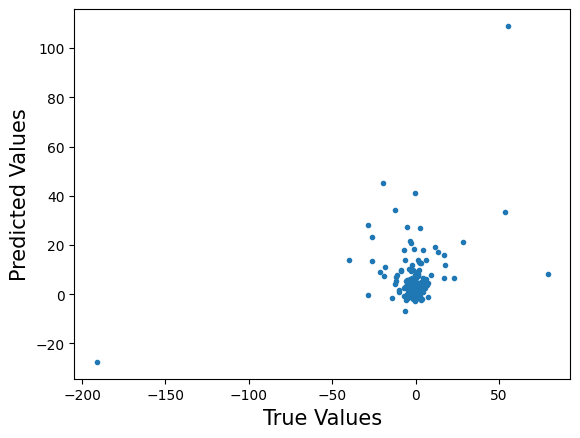

In [72]:
fig, ax = plt.subplots()

ax.scatter(y_test, predictions, marker='.')
ax.set_xlabel('True Values', fontsize=15)
ax.set_ylabel('Predicted Values', fontsize=15)
# ax.set_yscale('log')

In [73]:
np.argmin(predictions)

15

In [74]:
predictions[15]

-27.51384973386121

In [75]:
y_test.values[15]

-191.0691540250138

In [76]:
metrics.r2_score(y_test.values[16:], predictions[16:])

-0.7819571040436093

In [77]:
model.feature_importances_

array([ 0.        ,  1.47663944,  0.57531298,  0.12832477,  2.72272816,
        1.91329499,  3.5537175 , 13.40421743,  5.39390179,  2.36291668,
        4.88348401, 18.90686723,  4.12257359,  3.87494373,  9.74393924,
        4.85224242,  2.0411555 ,  5.49631369, 14.54742685])

In [78]:
pd.DataFrame({'Feature Importances':model.feature_importances_}, index=X_train.columns)

,Feature Importances
COAST,0.000000
DIST_MAIN,1.476639
DIST_SINK,0.575313
ENDO,0.128325
Glacier_max,2.722728
Glacier_means,1.913295
Glacier_min,3.553717
Glacier_stdev,13.404217
SUB_AREA,5.393902
UP_AREA,2.362917
